# **Chapter 6: Color image processing**
In this notebook we explore practical color image processing: we compare color models (RGB and HSV), apply pointwise transforms and histogram operations safely in color, extend spatial filtering to multi-channel data, and finish with pseudocolor techniques for grayscale scientific images. The examples build on a single color photograph and a medical CT slice to highlight both visual impact and pitfalls (like color distortion when equalizing channels independently).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float

plt.rcParams['image.cmap']='gray'
plt.rcParams['figure.figsize']=[10,6]

## Color models
The color image used in the following examples is available [here](https://drive.google.com/file/d/1OvVYhq--hyiriUSxgxUyRKtPL73xM0Qk/view?usp=sharing). We will inspect and manipulate its color components to understand how different representations behave.

In [2]:
I = io.imread('watch_color.png')

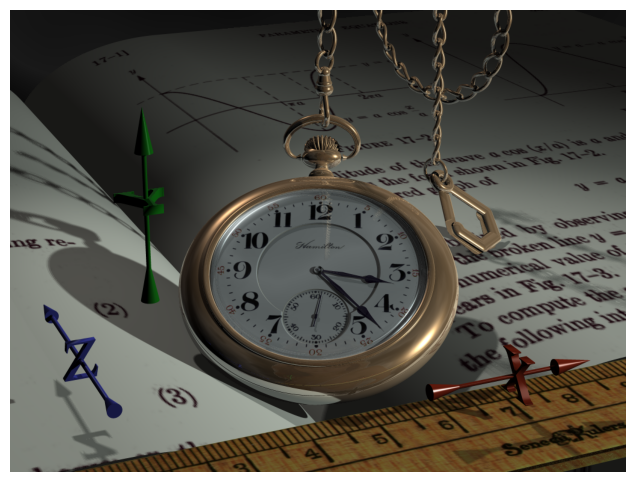

In [3]:
plt.imshow(I)
plt.axis('off');

### RGB model
The RGB color model represents a color image as three intensity channels $R$, $G$, and $B$. Below we display each channel as a grayscale image and observe that their structures are very similar, indicating strong correlation between components for natural scenes.

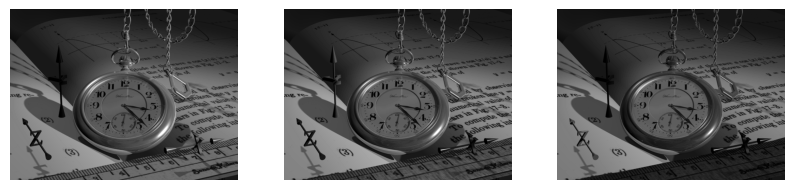

In [4]:
plt.subplot(131)
plt.imshow(I[:,:,0],'gray')
plt.axis('off');
plt.subplot(132)
plt.imshow(I[:,:,1],'gray')
plt.axis('off');
plt.subplot(133)
plt.imshow(I[:,:,2],'gray')
plt.axis('off');

If we multiply the last component (the $B$-channel) by $1.5$, the image shifts towards blue. This simple operation demonstrates how channel-wise scaling in RGB changes color balance without altering spatial structure.

In [5]:
K = np.copy(I)
K[:,:,2] = (1.5*K[:,:,2]).clip(0,255)

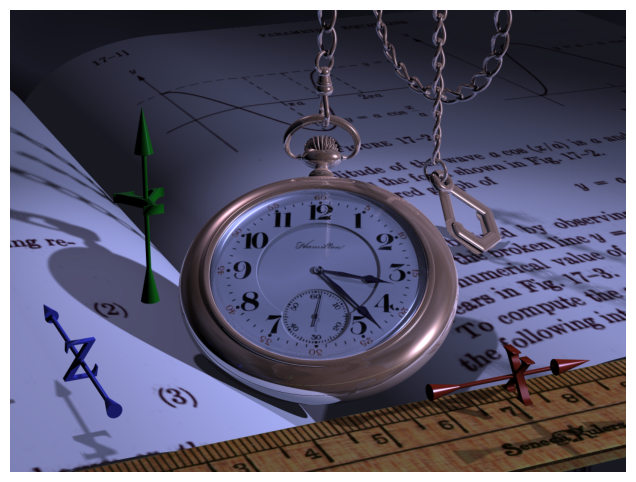

In [6]:
plt.imshow(K)
plt.axis('off');

### HSV model
The `scikit-image` package provides the HSV model (Hue–Saturation–Value) instead of HSI; in HSI the intensity is the arithmetic mean of $R$, $G$, and $B$, whereas in HSV the $V$ component stores brightness while $H$ encodes the dominant wavelength and $S$ the purity of color. We convert the image to HSV and show each component as a grayscale image to clarify their distinct roles.

In [7]:
hsv = color.rgb2hsv(I)

In [8]:
plt.subplot(131)
plt.imshow(hsv[:,:,0],'gray')
plt.axis('off');
plt.subplot(132)
plt.imshow(hsv[:,:,1],'gray')
plt.axis('off');
plt.subplot(133)
plt.imshow(hsv[:,:,2],'gray')
plt.axis('off');

Next, we maximize the saturation channel $S$ while keeping $H$ and $V$ unchanged. This pushes all chromatic pixels to fully saturated colors defined by their hue, producing a vivid, “pure color” version of the scene.

In [9]:
hsv[:,:,1] = 1

In [10]:
rgb = color.hsv2rgb(hsv)

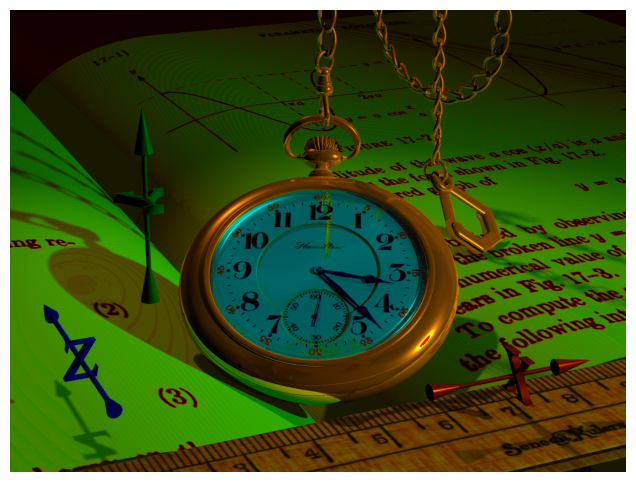

In [11]:
plt.imshow(rgb)
plt.axis('off');

## Spatial domain processing of color images
Image processing operations (e.g., intensity transforms) can be applied channel-wise. In the next example we apply a power-law transformation $x^{0.5}$ to brighten midtones; the accompanying original image confirms the effect is strongest where intensities are moderate.

In [12]:
hsv = color.rgb2hsv(I)
hsv[:,:,2] = hsv[:,:,2]**0.5
rgb = color.hsv2rgb(hsv)

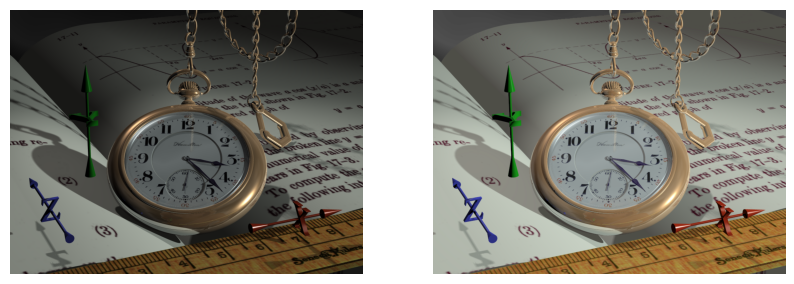

In [13]:
plt.subplot(121)
plt.imshow(I)
plt.axis('off');
plt.subplot(122)
plt.imshow(rgb)
plt.axis('off');

### Histogram equalization
Performing histogram equalization separately on $R$, $G$, and $B$ enhances contrast but typically distorts colors because each channel is remapped differently. We illustrate this by equalizing each channel independently and comparing the result to the original.

In [14]:
from skimage.exposure import equalize_hist

In [15]:
rgb = np.zeros_like(I).astype('float')

In [16]:
rgb[:,:,0] = equalize_hist(I[:,:,0])
rgb[:,:,1] = equalize_hist(I[:,:,1])
rgb[:,:,2] = equalize_hist(I[:,:,2])

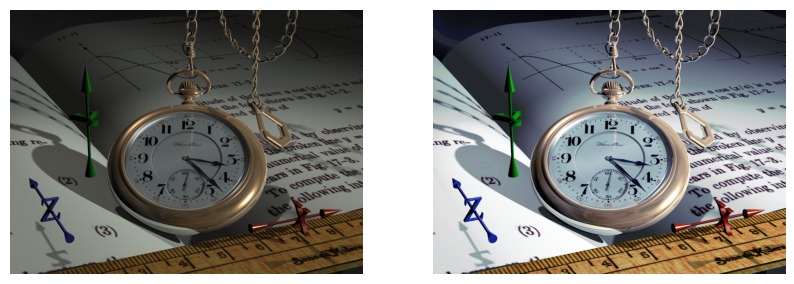

In [17]:
plt.subplot(121)
plt.imshow(I)
plt.axis('off');
plt.subplot(122)
plt.imshow(rgb)
plt.axis('off');

To avoid such color shifts, we convert the image to HSV, equalize only the $V$ (value/brightness) component, and convert back to RGB. This improves contrast while preserving the original hues and perceived colors.

In [18]:
hsv = color.rgb2hsv(I)
hsv[:,:,2] = equalize_hist(hsv[:,:,2])
rgb = color.hsv2rgb(hsv)

In [19]:
plt.subplot(121)
plt.imshow(I)
plt.axis('off');
plt.subplot(122)
plt.imshow(rgb)
plt.axis('off');

### Mean filtering
Spatial smoothing extends naturally to color images by convolving each channel with a kernel. Here we use a $7\times7$ average filter applied independently per channel, which reduces noise and small texture while blurring edges.

In [20]:
filt = np.ones((7,7,1))/49

In [21]:
from scipy.ndimage import convolve

In [22]:
F = convolve(rgb,filt)

In [23]:
plt.imshow(F)
plt.axis('off');

### Mean filtering over channels
Alternatively, we can average across channels (e.g., with a $3\times1$ kernel in the channel axis) to reduce inter-channel discrepancies. This tends to desaturate the image and push it toward gray, as shown below.

In [24]:
filt3d = np.ones((7,7,3))/147

In [25]:
G = convolve(rgb,filt3d)

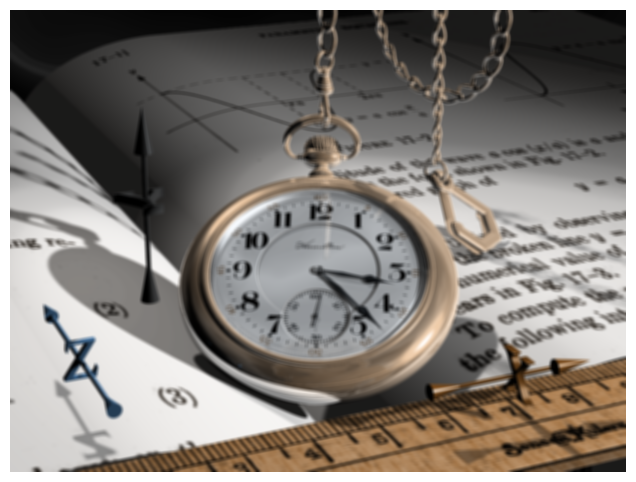

In [26]:
plt.imshow(G)
plt.axis('off');

## Pseudocolor image processing
We now examine pseudocolor visualization for scalar images using a medical head CT slice available [here](https://drive.google.com/file/d/1UN1veBz-0gQojwTkCMYPFzD-gZtOjyo_/view?usp=share_link). The raw grayscale rendering reveals the skull but hides subtle soft-tissue detail, motivating intensity remapping and colorization.

In [27]:
I = io.imread('ct-brain.tif')

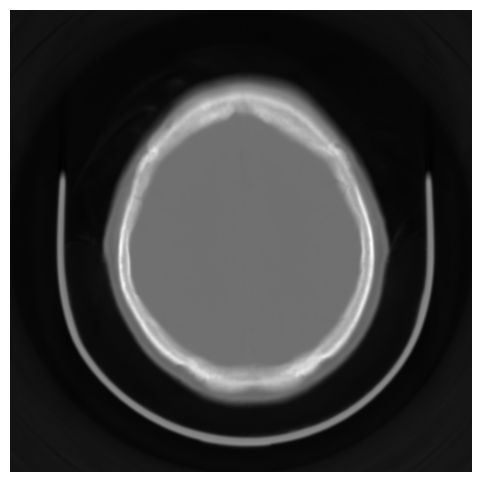

In [28]:
plt.imshow(I,'gray')
plt.axis('off');

Then we plot the intensity histogram to understand how values are distributed and to identify useful display windows. The CT data is stored at 12-bit precision, so intensities span a much wider range than typical 8-bit images.

In [29]:
from skimage.exposure import histogram

In [30]:
h,x = histogram(I)

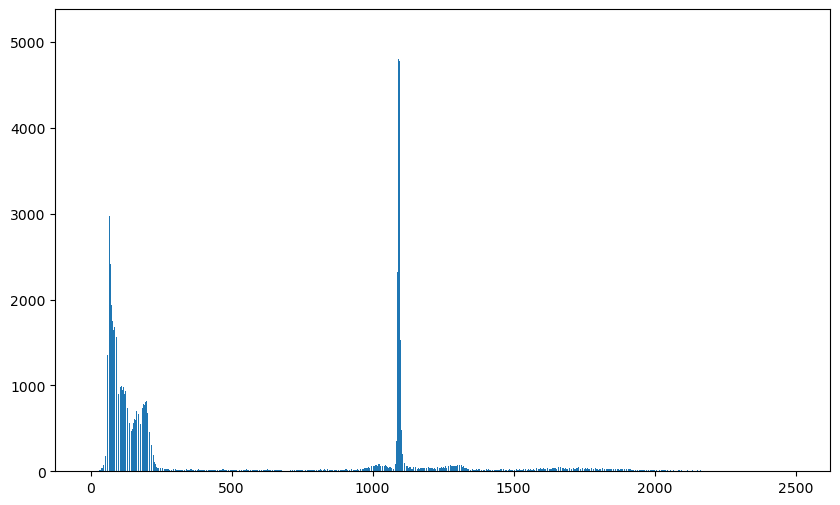

In [31]:
plt.bar(x,h);

The diagnostically interesting window lies roughly between 1000 and 1200 (in the image’s native units). We zoom into this interval to inspect variation that is invisible at full dynamic range.

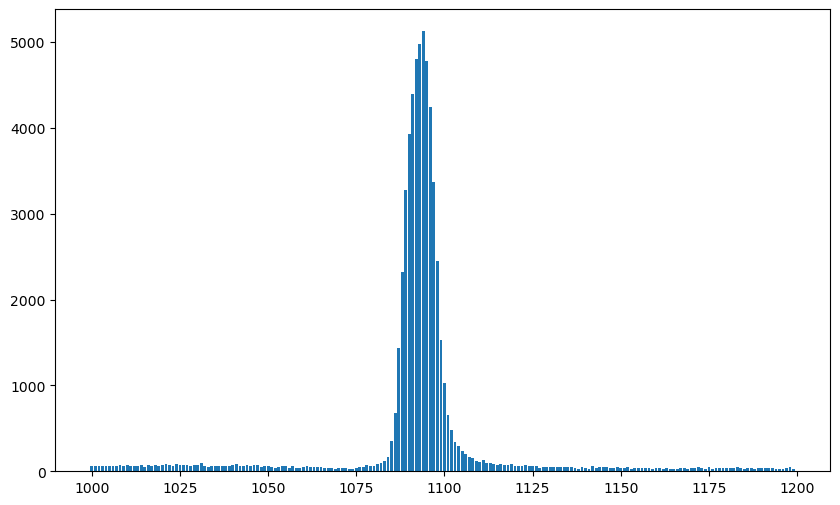

In [32]:
plt.bar(x[1000:1200],h[1000:1200]);

We define a binary mask for intensities in the target window, $I\in(1060,1125)$, to isolate relevant structures. This selection helps suppress background and bone while focusing on soft-tissue detail.

In [33]:
mask = np.logical_and(I>1060,I<1125)

In [34]:
plt.imshow(mask,'gray')
plt.axis('off');

Using the mask, we zero out other regions and shift the remaining intensities by 1060 to re-center the window. This windowing exposes otherwise hidden features in the brain parenchyma.

In [35]:
R = mask*(I-1060)

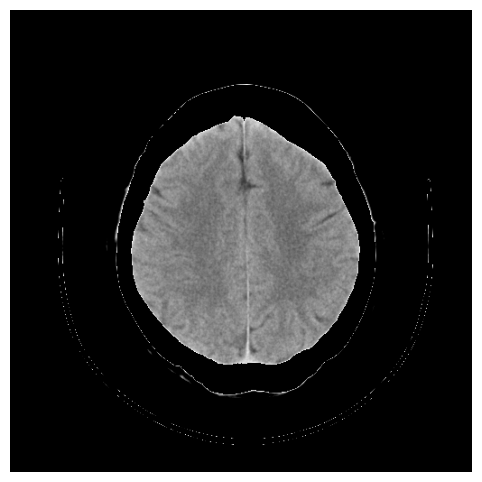

In [36]:
plt.imshow(R,'gray')
plt.axis('off');

To emphasize these details, we map the windowed intensities to color using the `'inferno'` colormap, which preserves perceptual ordering and contrast. Pseudocolor helps separate small variations that grayscale alone might miss.

In [37]:
plt.imshow(R,'inferno')
plt.axis('off');

We can further increase local contrast by first equalizing the windowed intensities and then applying the same colormap. This two-step approach improves visibility of faint structures without changing their relative order.

In [38]:
from skimage import exposure

In [39]:
H = exposure.equalize_hist(R)

In [40]:
plt.imshow(H,'inferno')
plt.axis('off');

### Intensity to color transformation
Most built-in colormaps are predefined, but we can design one by specifying three 1D transfer functions for $R$, $G$, and $B$ over the normalized intensity domain. In the following example we use sinusoidal waveforms with different frequencies to create a custom mapping.

In [41]:
(R.min(), R.max())

(0, 64)

Our grayscale image has dynamic range 65, so we sample $t\in[0,1]$ at 65 points and define $R(t)$, $G(t)$, and $B(t)$ with frequencies $1$, $1.75$, and $2.25$, respectively. These curves form a $65\times3$ table that maps each intensity to a color.

In [42]:
t = np.linspace(0,1,65)

In [43]:
s1 = np.abs(np.sin(2*np.pi*t))
s2 = np.abs(np.sin(3.5*np.pi*t))
s3 = np.abs(np.sin(4.5*np.pi*t))

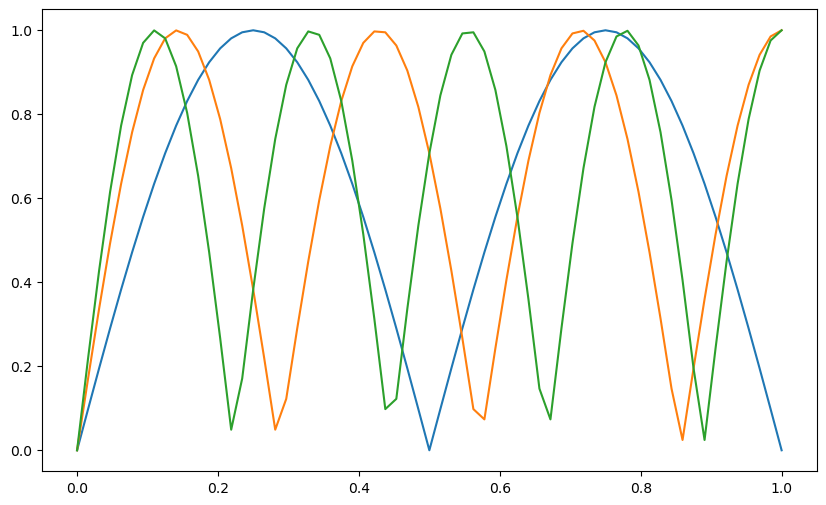

In [44]:
plt.plot(t,s1)
plt.plot(t,s2)
plt.plot(t,s3);

Finally, we apply the custom transformation to the intensity image to produce a pseudocolor rendering. The resulting visualization reveals structures that were not apparent with the previous settings, illustrating how choice of colormap affects perception.

In [45]:
T = np.vstack((s1,s2,s3)).T

In [46]:
K = T[R,:]

In [47]:
plt.imshow(K)
plt.axis('off');